# Homework 4

In [ ]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
from imageio import imread, imsave
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2

from skimage.color import rgb2gray
import skimage.io as io
from skimage.feature import plot_matches

# Panorama Stiching

## Problem 1

In [ ]:
def plot_imageset(images, figsize=(18, 8), title="Figure"):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)

    for ax, im in zip(grid, images):
        ax.set_axis_off()
        if len(im.shape) < 3:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)

    fig.suptitle(title)
    plt.show()

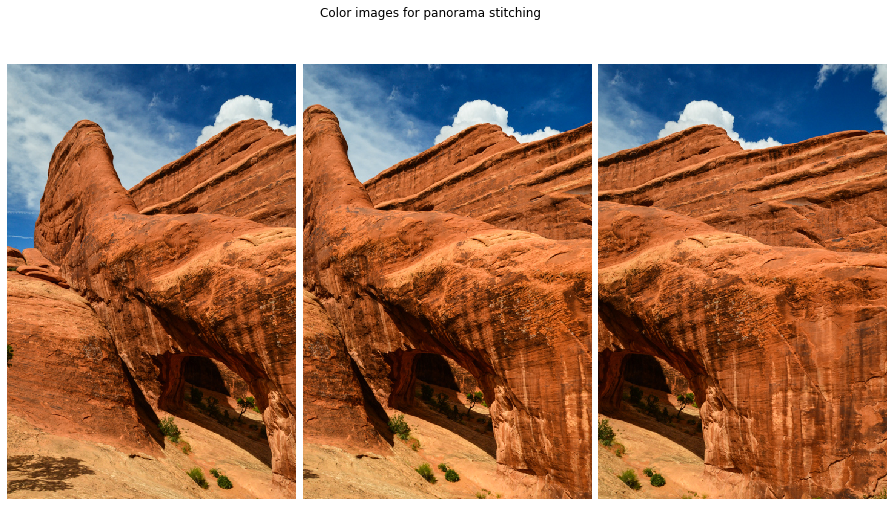

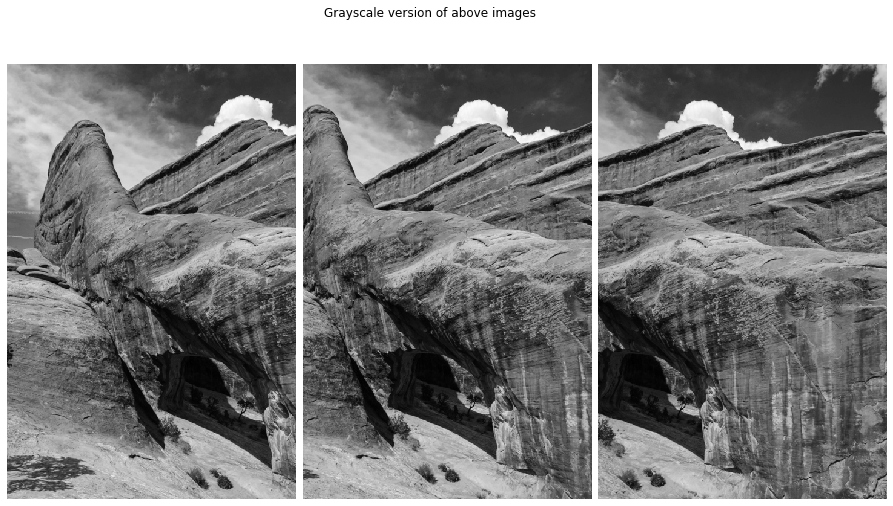

In [ ]:
pano_paths = sorted(glob.glob('data/JDW_03*'))
pano_imgs = [imread(path) for path in pano_paths]
plot_imageset(pano_imgs, title = 'Color images for panorama stitching')

pano0, pano1, pano2 = [cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in pano_imgs]
plot_imageset([pano0, pano1, pano2], title = "Grayscale version of above images")

## Problem 2

### Detect features and plot matches

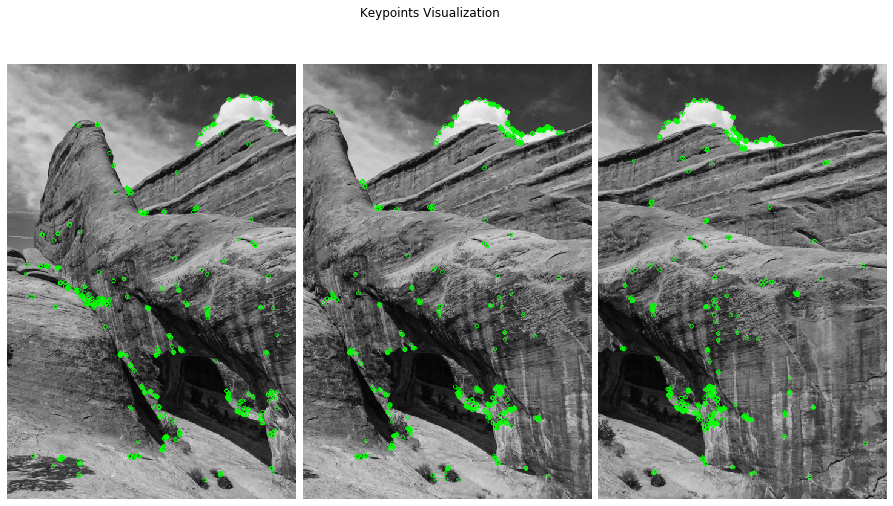

In [ ]:
orb = cv2.ORB_create()

keypoints0, descriptors0 = orb.detectAndCompute(pano0, None)
keypoints1, descriptors1 = orb.detectAndCompute(pano1, None)
keypoints2, descriptors2 = orb.detectAndCompute(pano2, None)

plot_imageset([cv2.drawKeypoints(pano0,keypoints0,None,color=(0,255,0)),
               cv2.drawKeypoints(pano1,keypoints1,None,color=(0,255,0)),
               cv2.drawKeypoints(pano2,keypoints2,None,color=(0,255,0))], title = "Keypoints Visualization")

plt.show()

In [ ]:
# Match the descriptors 
# opencv: easiest is probably cv2.BFMatcher

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors0, descriptors1)
matches_01 = sorted(matches, key = lambda x : x.distance)

matches = bf.match(descriptors1, descriptors2)
matches_12 = sorted(matches, key = lambda x : x.distance)

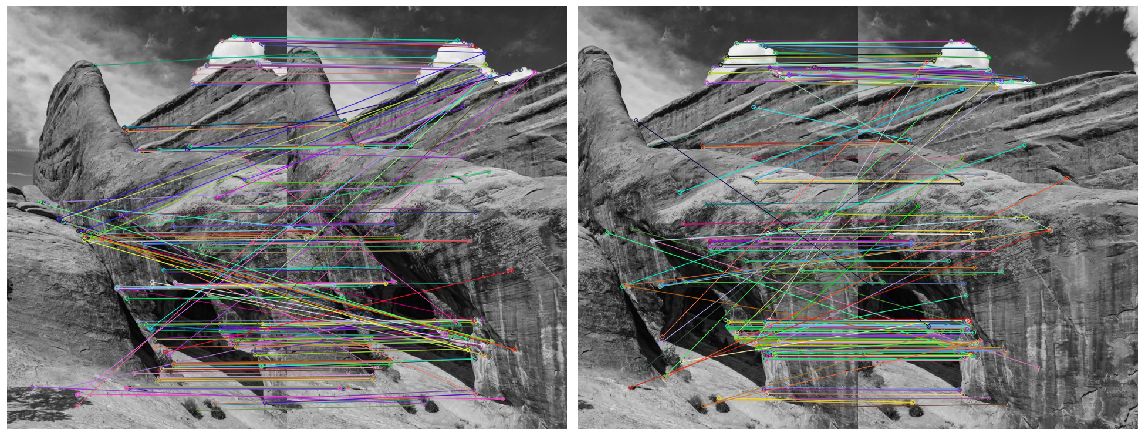

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
plt.gray()

im_01 = cv2.drawMatches(pano0, keypoints0, pano1, keypoints1, matches_01,
                        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

im_12 = cv2.drawMatches(pano1, keypoints1, pano2, keypoints2, matches_12,
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ax[0].imshow(im_01)
ax[0].axis('off')

ax[1].imshow(im_12)
ax[1].axis('off')

plt.tight_layout()
plt.show()

We clearly see a lot of false positives. We also observe that for corners (with big difference in color intensity), and blobs, the correspondenses are better. In the darker areas, and where the change in color intensity is not high enough, the correspondense is not great.

## Problem 3

### Homography + RANSAC

In this section, I played with three combinations of parameters, i.e. $(Residual\ Threshold, maxIters)\in\ \{(10, 10),\ (4, 25), (2, 50)\}$. The last combination, i.e. a residual threshold of $4$ and a maximum of $50$ iterations, gave me the best results, i.e. all of the outliers seem to have been removed, but still a healthy number of inliers were retained for the homography calculation.

In [ ]:
#opencv: cv2.findHomography with cv2.RANSAC

kps0 = np.float32([kp.pt for kp in keypoints0])
kps1 = np.float32([kp.pt for kp in keypoints1])

pts0 = np.float32([kps0[m.queryIdx] for m in matches_01])
pts1 = np.float32([kps1[m.trainIdx] for m in matches_01])

(H01, status_01) = cv2.findHomography(pts0, pts1, cv2.RANSAC, 2, maxIters = 50)

kps1 = np.float32([kp.pt for kp in keypoints1])
kps2 = np.float32([kp.pt for kp in keypoints2])

pts1 = np.float32([kps1[m.queryIdx] for m in matches_12])
pts2 = np.float32([kps2[m.trainIdx] for m in matches_12])

(H12, status_12) = cv2.findHomography(pts2, pts1, cv2.RANSAC, 2, maxIters = 50)

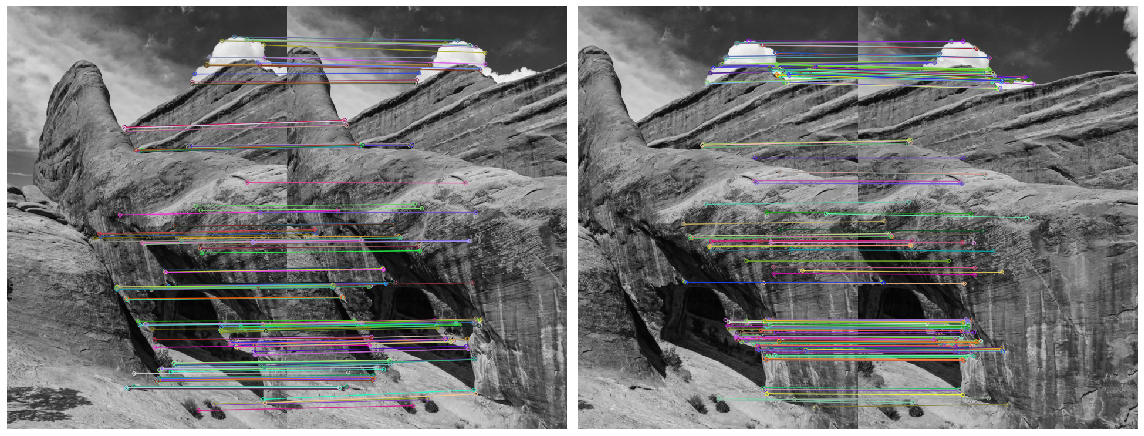

In [ ]:
# plotting the inliers for homography estimation with ransac. looks much better!

inliers_01 = [matches_01[_] for _ in range(len(matches_01)) if status_01[_] == 1]
inliers_12 = [matches_12[_] for _ in range(len(matches_12)) if status_12[_] == 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
plt.gray()

im_01 = cv2.drawMatches(pano0, keypoints0, pano1, keypoints1, inliers_01,
                        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

im_12 = cv2.drawMatches(pano1, keypoints1, pano2, keypoints2, inliers_12,
                        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ax[0].imshow(im_01)
ax[0].axis('off')

ax[1].imshow(im_12)
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Problem 4

### Warping and Blending

In [ ]:
# Shape of middle image, our registration target
r0, c0 = pano0.shape[:2]
r1, c1 = pano1.shape[:2]
r2, c2 = pano2.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners0 = np.array([[0, 0], [0, r0], [c0, 0], [c0, r0]])
corners1 = np.array([[0, 0], [0, r1], [c1, 0], [c1, r1]])
corners2 = np.array([[0, 0], [0, r2], [c2, 0], [c2, r2]])

# Warp the image corners to their new positions
warped_corners01 = np.hstack([corners0, np.array([1,1,1,1])[:, np.newaxis]])@H01.T
warped_corners01 = warped_corners01[:,:2]/np.vstack([warped_corners01[:,2]]*2).T # apply transform0->1 to corners
warped_corners12 = np.hstack([corners2, np.array([1,1,1,1])[:, np.newaxis]])@H12.T
warped_corners12 = warped_corners12[:,:2]/np.vstack([warped_corners12[:,2]]*2).T # apply transform1->2 to corners

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners1, warped_corners12))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Applying the warps

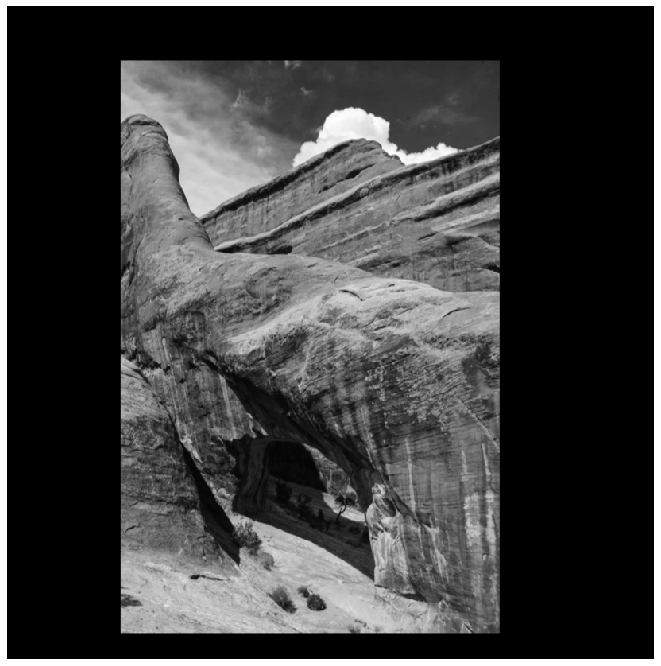

In [ ]:
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from cv2 import warpAffine
from cv2 import warpPerspective


# Use one of the quantities computed above to find the correct offset for middle image
offset1 = np.array([[1,0,-corner_min[0]],[0,1,-corner_min[1]],[0,0,1]])#

# Translate pano1 into place
pano1_warped = cv2.warpPerspective(pano1, offset1, tuple([output_shape[1], output_shape[0]]))

plt.figure(figsize=(12, 12))
plt.imshow(pano1_warped, cmap='gray')
plt.axis('off')
plt.show()

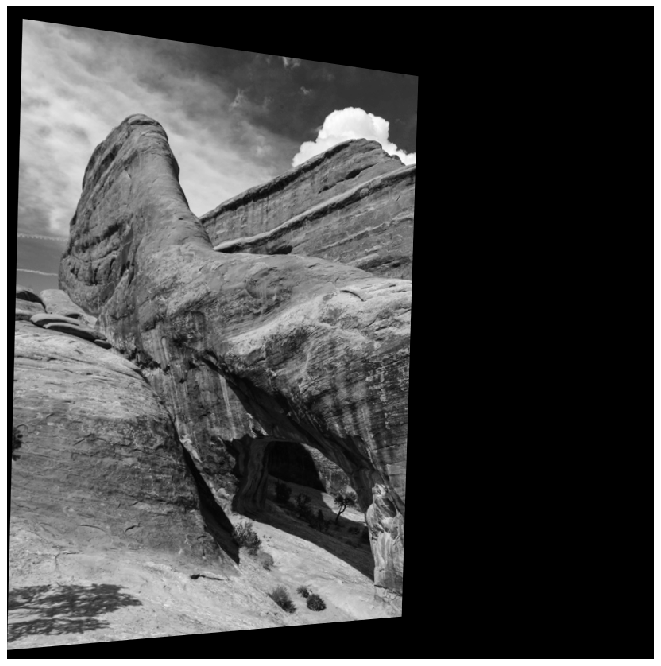

In [ ]:
# Warp the left image into place
pano0_warped = cv2.warpPerspective(pano0, offset1@H01, tuple([output_shape[1], output_shape[0]]))

plt.figure(figsize=(12, 12))
plt.imshow(pano0_warped, cmap='gray')
plt.axis('off')
plt.show()
#pano0_mask = #

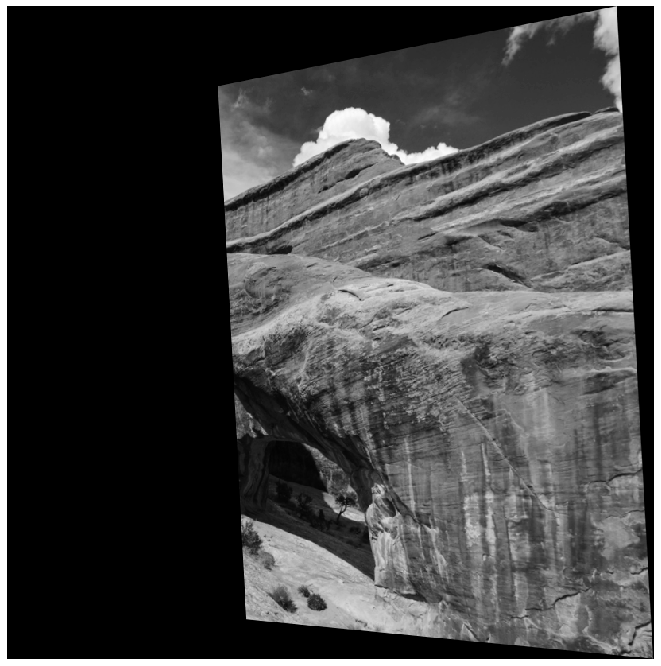

In [ ]:
# Warp the right image into place
pano2_warped = cv2.warpPerspective(pano2, offset1@H12, tuple([output_shape[1], output_shape[0]]))

plt.figure(figsize=(12, 12))
plt.imshow(pano2_warped, cmap='gray')
plt.axis('off')
plt.show()

### Blend images into panorama

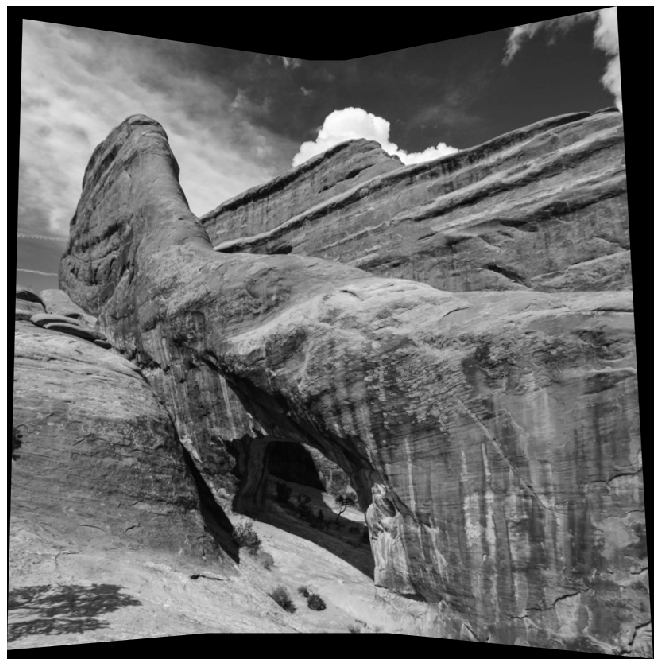

In [ ]:
# use [pano0_warped, pano1_warped, pano2_warped] and [pano0_mask, pano1_mask, pano2_mask]
# to obtain normalized panorama image

normalized = np.maximum(np.maximum(pano0_warped, pano1_warped), pano2_warped)

plt.figure(figsize=(12, 12))
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.show()

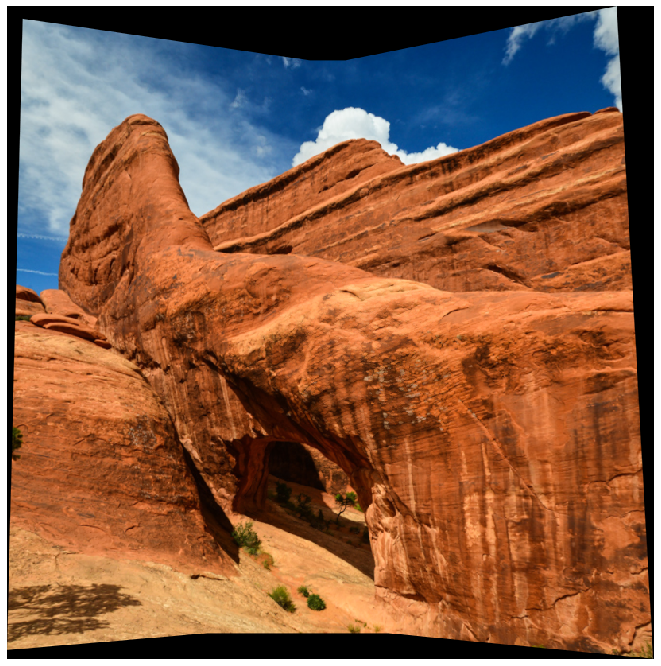

In [ ]:
pano0_color = cv2.warpPerspective(pano_imgs[0], offset1@H01, tuple([output_shape[1], output_shape[0]]))
pano1_color = cv2.warpPerspective(pano_imgs[1], offset1, tuple([output_shape[1], output_shape[0]]))
pano2_color = cv2.warpPerspective(pano_imgs[2], offset1@H12, tuple([output_shape[1], output_shape[0]]))

normalized_color = np.maximum(np.maximum(pano0_color, pano1_color), pano2_color)

plt.figure(figsize=(12, 12))
plt.imshow(normalized_color)
plt.axis('off')
plt.show()

# Hough transform

## Problem 5

The Hough Transform voting space in this case shall be $5$ dimensional for a general ellipse (since we are not assuming that one of the axes of the ellipse is parallel to a coordinate axis). This can be understood by step by step transformation of the equation of an ellipse centered at the origin. We start from,
$$x(\alpha)\ =\ r_x \cos(\alpha),\qquad y(\alpha)\ =\ r_y \sin(\alpha)$$
where the parameter $\alpha$ can be varied to get different points on a considered ellipse. Then multiplying the coordinates by a rotation matrix (corresponding to $\theta$), and shifting the center to $(c_x,c_y)$, we get
$$x(\alpha)\ =\ r_x \cos(\alpha)\cos(\theta)-r_y \sin(\alpha)\sin(\theta)+c_x,\qquad y(\alpha)\ =\ r_x \cos(\alpha)\sin(\theta)+r_y \sin(\alpha)\cos(\theta)+c_y$$
Clearly, since $\alpha$ governs the choice of point on the ellipse, the equation of the ellipse itself is governed by 5 parameters, namely,

$\bullet\ c_x = $ x-coordinate of ellipse center, goes from 0 to $N$.

$\bullet\ c_y = $ y-coordinate of ellipse center, goes from 0 to $N$.

$\bullet\ r_x = $ Length of semi-major axis, goes from 0 to $\sqrt{2}N$, the diagonal of the image.

$\bullet\ r_y = $ Length of semi-minor axis, goes from 0 to $\sqrt{2}N$.

$\bullet\ \theta = $ Angle made by major axis of the ellipse with x-axis, and ranges from 0 to $2\pi$.

Thus we have a 5 dimensional space Hough Transform voting space.

## Problem 6

Given a point $(x,y)$ which may be on an ellipse, we can substitute in the values of $x$ and $y$ in the ellipse, and eliminate $\alpha$, to get a relation between the 5 parameters of the HT space, i.e.
$$x - c_x\ =\ r_x \cos(\alpha)\cos(\theta) - r_y \sin(\alpha)\sin(\theta)$$
$$y - c_y\ =\ r_x \cos(\alpha)\sin(\theta) + r_y \sin(\alpha)\cos(\theta)$$
Solving these 2 equations for $\alpha$ gives us
$$\cos(\alpha) = \frac{1}{r_x}[(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]$$
$$\sin(\alpha) = \frac{1}{r_y}[(y-c_y)\cos(\theta)-(x-c_x)\sin(\theta)]$$
Now, $\cos^2(\alpha)+\sin^2(\alpha)=1$ gives us that,
$$r^2_y[(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2 + r^2_x[(y-c_y)\cos(\theta)-(x-c_x)\sin(\theta)]^2\ =\ 1$$
If we take $c_x$ as the dependent variable, and the rest as independent ones, we get
$$r_x\ =\ \frac{\sqrt{1\ -\ r^2_y[(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}}{(y-c_y)\cos(\theta)-(x-c_x)\sin(\theta)}$$
Hence, in the 5 dimensional voting space, the formula of the vote becomes,
$$\left(c_x,\ c_y,\ \frac{\sqrt{1\ -\ r^2_y[(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}}{(y-c_y)\cos(\theta)-(x-c_x)\sin(\theta)},\ r_y,\ \theta\right)$$

## Problem 7

Say we are given that in the ellipses under consideration, we have $r_x\ =\ kr_y$, i.e. the aspect ratio equals $k$. This simply decreases a degree of freedom, and hence the HT voting space will become 4-dimensional (which will significantly quicken the runtime). For the voting, we only need to solve the 2 equations:
$$r_x\ =\ kr_y\ =\ \frac{\sqrt{1\ -\ r^2_y[(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}}{(y-c_y)\cos(\theta)-(x-c_x)\sin(\theta)}$$
$$\therefore\ \ r_y\ =\ \frac{1}{k^2[(y-c_y)\cos(\theta) - (x-c_x)\sin(\theta)]^2\ +\ [(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}$$
Hence, the new vote becomes,
$$\left(c_x,\ c_y,\ \frac{k}{\sqrt{k^2[(y-c_y)\cos(\theta) - (x-c_x)\sin(\theta)]^2\ +\ [(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}},\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \frac{1}{\sqrt{k^2[(y-c_y)\cos(\theta) - (x-c_x)\sin(\theta)]^2\ +\ [(y-c_y)\sin(\theta)+(x-c_x)\cos(\theta)]^2}},\ \theta\right)$$